In [0]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Data loading from csv
dataframe = pd.read_csv('consumercomplaints.csv')
dataframe.shape


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1383226, 18)

In [0]:
dataframe.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,09/13/2019,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,NaN,NaN,CONTRACT CALLERS INC,AZ,85203,NaN,NaN,Web,09/13/2019,In progress,Yes,NaN,3372697
1,09/13/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,"Diversified Consultants, Inc.",NJ,07311,NaN,NaN,Web,09/13/2019,In progress,Yes,NaN,3373295
2,09/13/2019,"Payday loan, title loan, or personal loan",Payday loan,Problem with the payoff process at the end of ...,NaN,NaN,NaN,CURO Intermediate Holdings,CA,94931,NaN,NaN,Web,09/13/2019,Closed with explanation,Yes,NaN,3373845
3,09/13/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,NaN,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",GA,31088,Servicemember,Consent not provided,Web,09/13/2019,Closed with explanation,Yes,NaN,3372694
4,09/13/2019,"Payday loan, title loan, or personal loan",Personal line of credit,Problem when making payments,NaN,NaN,Company has responded to the consumer and the ...,"Prosper Marketplace, Inc.",KY,40515,NaN,NaN,Web,09/13/2019,Closed with explanation,Yes,NaN,3373971


In [0]:
# Creating a new dataframe with only the two features we need
dataframe1 = dataframe[['Product', 'Consumer complaint narrative']].copy()

# NaN values are removed (null)
dataframe1 = dataframe1[pd.notnull(dataframe1['Consumer complaint narrative'])]

# Consume complaint narrative is renamed as Complaint
dataframe1.columns = ['Product', 'Complaint'] 

dataframe1.shape

(438660, 2)

https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars

In [0]:
# Percentage of actual complaints (not null)
total = dataframe1['Complaint'].notnull().sum()
round((total/len(dataframe)*100),1)

31.7

In [0]:
pd.DataFrame(dataframe.Product.unique()).values

array([['Debt collection'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit card or prepaid card'],
       ['Vehicle loan or lease'],
       ['Checking or savings account'],
       ['Student loan'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Other financial service'],
       ['Consumer Loan'],
       ['Payday loan'],
       ['Prepaid card'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

In [0]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = dataframe1.sample(10000, random_state=1).copy()

In [0]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [0]:
pd.DataFrame(df2.Product.unique())

,0
0,Debt collection
1,Student loan
2,Checking or savings account
3,Consumer Loan
4,Mortgage
5,Credit card or prepaid card
6,"Credit reporting, repair, or other"
7,Vehicle loan or lease
8,"Money transfer, virtual currency, or money ser..."
9,Bank account or service


In [0]:
# A new column 'CategoryId' is created to maintain categories
df2['CategoryId'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'CategoryId']].drop_duplicates()
#del df2['CategoryId']

# Dictionaries to make search easier later
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['CategoryId', 'Product']].values)

# Resulted dataframe with categories
df2.head(10)

,Product,Complaint,CategoryId
88396,Debt collection,on XX/XX/19 commenity capital bank called a re...,0
672838,Student loan,I co signed XXXX loans for my son years ago wi...,1
450389,Checking or savings account,I was involved in an online relationship with ...,2
649714,Consumer Loan,I purchased a XXXX XXXX XXXX truck from XXXX X...,3
907024,Debt collection,A man called from a company called RMB - which...,0
408205,Debt collection,""" Credence Resource Management '' has called m...",0
1000587,Debt collection,I am victim of fraud and someone stole my iden...,0
72085,Debt collection,"I received a notice from The Advantage Group, ...",0
18312,Mortgage,Account # XXXXThrough Freedom MortgageMy accou...,4
255813,Credit card or prepaid card,On XX/XX/2018 I used my credit card to rent a ...,5


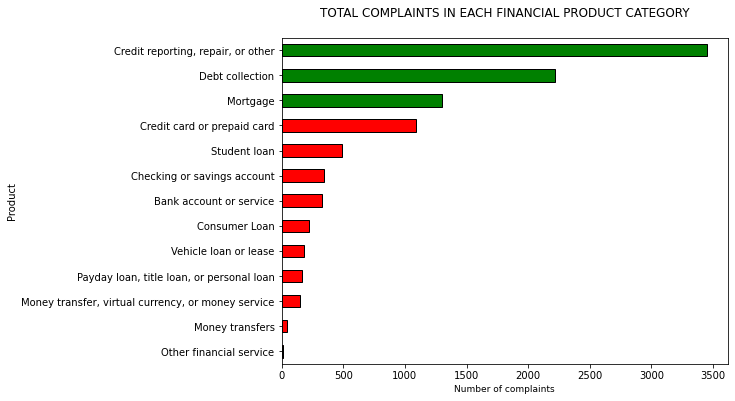

In [0]:
fig = plt.figure(figsize=(8,6))
colors = ['red','red','red','red','red','red','red','red','red',
    'red','green','green','green']
df2.groupby('Product').Complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, edgecolor='black', title= 'TOTAL COMPLAINTS IN EACH FINANCIAL PRODUCT CATEGORY\n')
plt.xlabel('Number of complaints', fontsize = 9);

In [0]:
tfidf_score = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english')

# Transforming complaint into a vector
features = tfidf_score.fit_transform(df2.Complaint).toarray()

labels = df2.CategoryId

print("Every sample (%d) complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Every sample (10000) complaints is represented by 27614 features (TF-IDF score of unigrams and bigrams)


In [0]:
# Three most correlated terms in each of the product categories
N = 3
for Product, CategoryId in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == CategoryId)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf_score.get_feature_names())[indices]

  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  print("\n==> %s:" %(Product))
  print("  # Top Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  # Top Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  # Top Correlated Unigrams are: checking, citigold, overdraft
  # Top Correlated Bigrams are: overdraft fees, citigold checking, checking account

==> Checking or savings account:
  # Top Correlated Unigrams are: bank, atm, deposit
  # Top Correlated Bigrams are: savings account, debit card, checking account

==> Consumer Loan:
  # Top Correlated Unigrams are: car, ally, vehicle
  # Top Correlated Bigrams are: loan charged, hyundai motor, motor finance

==> Credit card or prepaid card:
  # Top Correlated Unigrams are: capital, express, card
  # Top Correlated Bigrams are: balance transfer, american express, credit card

==> Credit reporting, repair, or other:
  # Top Correlated Unigrams are: report, experian, equifax
  # Top Correlated Bigrams are: xxxx experian, credit file, credit report

==> Debt collection:
  # Top Correlated Unigrams are: collect, collection, debt
  # Top Correlated Bigrams are: debt collection, collection agency, collect debt

==> M

In [0]:
X = df2['Complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [0]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  Model_Name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((Model_Name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['Model_Name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [0]:
mean_accuracy = cv_df.groupby('Model_Name').accuracy.mean()
std_accuracy = cv_df.groupby('Model_Name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
Model_Name,,
LinearSVC,0.7807,0.004791
LogisticRegression,0.7633,0.005574
MultinomialNB,0.6385,0.007616
RandomForestClassifier,0.3813,0.002775


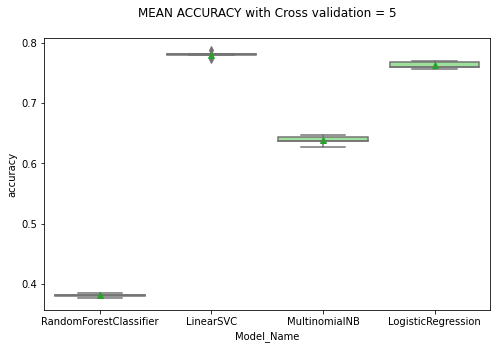

In [0]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Model_Name', y='accuracy', 
            data=cv_df, 
            color='lightgreen', 
            showmeans=True)
plt.title("MEAN ACCURACY with Cross validation = 5\n", size=12);

In [0]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [0]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                                   Debt collection       0.77      0.82      0.79       557
                                      Student loan       0.79      0.73      0.76       116
                       Checking or savings account       0.51      0.54      0.53        83
                                     Consumer Loan       0.33      0.17      0.22        60
                                          Mortgage       0.84      0.94      0.89       309
                       Credit card or prepaid card       0.78      0.80      0.79       305
                Credit reporting, repair, or other       0.82      0.88      0.85       841
                             Vehicle loan or lease       0.56      0.30      0.39        47
Money transfer, virtual currency, or money service       0.87      0.50      0.63        40
                           Bank account or service

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


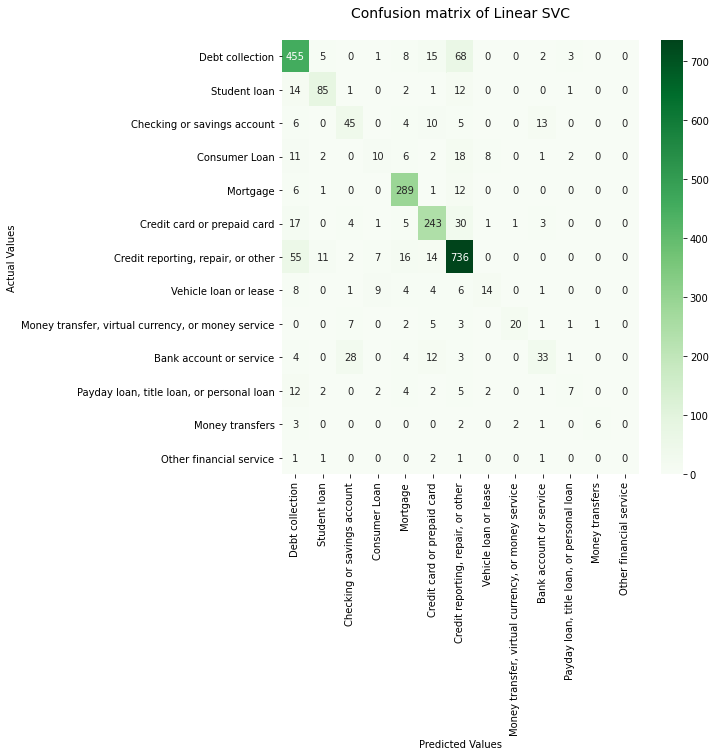

In [0]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.title("Confusion matrix of Linear SVC\n", size=14);

In [0]:
for predicted in category_id_df.CategoryId:
  for actual in category_id_df.CategoryId:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Complaint']])
      print('')

'Credit reporting, repair, or other' predicted as 'Debt collection' : 55 examples.


,Product,Complaint
530285,"Credit reporting, repair, or other",This is regarding an adverse account item logg...
187680,"Credit reporting, repair, or other",XXXX XXXX XXXX XXXX has violated x 15 USC 1692...
255990,"Credit reporting, repair, or other",I disputed an acct that is illegally being rep...
767126,"Credit reporting, repair, or other",Wrong Information on my Credit
130812,"Credit reporting, repair, or other",Emergency room visit year XX/XX/2012. I was un...
961806,"Credit reporting, repair, or other","Well, 4-5 years ago I had cable XXXX and alway..."
959553,"Credit reporting, repair, or other",On my credit report. It says I owe XXXX to som...
569822,"Credit reporting, repair, or other",XXXX XXXX XXXX XXXX has invaded my credit repo...
333919,"Credit reporting, repair, or other",The referenced collection agency has violated ...
673989,"Credit reporting, repair, or other",I went to buy a house ... ... ... .My credit r...



'Bank account or service' predicted as 'Checking or savings account' : 28 examples.


,Product,Complaint
739529,Bank account or service,I recall seeing statements from Wells Fargo bu...
813086,Bank account or service,I had an insured money director account in XXX...
894764,Bank account or service,I 'm XXXX and XXXX and XXXX and also will be f...
688817,Bank account or service,I closed XXXX accounts with my bank when I mov...
886894,Bank account or service,There is an ongoing dispute between myself and...
781571,Bank account or service,Wells Fargo 's last letter to me stated that I...
875623,Bank account or service,I am unable to open a checking account in the ...
764321,Bank account or service,On XXXX/XXXX/XXXX I received a deposit refund ...
639875,Bank account or service,"XXXX Re your inquiry for more information, i h..."
722680,Bank account or service,"Without notifying me, BBVA Compass closed both..."



'Debt collection' predicted as 'Credit reporting, repair, or other' : 68 examples.


,Product,Complaint
91262,Debt collection,FCRA 611 ( 15 U.S.C. 1681I ) PROCEDURE IN CASE...
960040,Debt collection,account was paid off on XXXX/XXXX/15. Confirma...
770005,Debt collection,I was XXXX when this all took place so this sh...
84801,Debt collection,I am contacting you about the compromising of ...
145136,Debt collection,I pulled all 3 of my credit reports to find ou...
...,...,...
982574,Debt collection,"In XX/XX/XXXX, I contacted via letter disputes..."
576969,Debt collection,I recently reviewed my credit report ( because...
351578,Debt collection,I am sorry that I keep opening a new complaint...
694853,Debt collection,I paid in the accounts with conns credit on ti...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 30 examples.


,Product,Complaint
768425,Credit card or prepaid card,In XXXX XXXX I contacted Capital One and it vi...
206258,Credit card or prepaid card,XXXX has been non-compliant with removing the ...
926047,Credit card or prepaid card,Back in XX/XX/XXXX2015 my Chase credit card wa...
118317,Credit card or prepaid card,Bank Re-opened and Closed their online portal ...
447854,Credit card or prepaid card,XXXX has reported to all 3 credit bureaus that...
483640,Credit card or prepaid card,"XXXX XXXX, XXXX cbna/thd company made a hard i..."
701329,Credit card or prepaid card,I submitted a previous complaint against tidew...
37176,Credit card or prepaid card,OnXX/XX/2019weflewtoXXXXXXXXandattheairportloo...
222016,Credit card or prepaid card,I recently looked at my credit reports and not...
814251,Credit card or prepaid card,TD Bank/ Target XXXX should be reporting a ZER...


In [0]:
model.fit(features, labels)

N = 4
for Product, CategoryId in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[CategoryId])
  feature_names = np.array(tfidf_score.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: bank, citigold, fradulent, usaa
  * Top bigrams: pay bills, citigold checking, usaa bank, checking xxxx

==> 'Checking or savings account':
  * Top unigrams: bank, atm, cd, deposit
  * Top bigrams: debit card, unauthorized charges, open bank, checking account

==> 'Consumer Loan':
  * Top unigrams: ally, vehicle, springleaf, car
  * Top bigrams: loan charged, took loan, authorize credit, finance xxxx

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, barclays, discover
  * Top bigrams: credit card, american express, late fee, balance transfer

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, inquiries
  * Top bigrams: xxxx xxxx, xxxx experian, trans union, contacted xxxx

==> 'Debt collection':
  * Top unigrams: debt, collect, collection, owe
  * Top bigrams: account unauthorized, violation knowledge, negative remarks, legal action

==> 'Money transfer, virtual currency, or mon

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [0]:
new_complaint = """I am Subhiksha, I am studying at Syracuse University. Recently, i have been harassed by \
Navient for the last month. I have taken a loan and paid it back with interests. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [0]:
df2[df2['Complaint'] == new_complaint]

,Product,Complaint,CategoryId


In [0]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [0]:
df2[df2['Complaint'] == new_complaint_2]

,Product,Complaint,CategoryId


In [0]:
nltk.download('vader_lexicon')

# SentimentIntensityAnalyser object is loaded
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
# function to get the negative score of a complaint
def negative_score(text):
    neg_value = analyzer.polarity_scores(text)['neg']
    return neg_value

# function to get the neutral score of a complaint
def neutral_score(text):
    neu_value = analyzer.polarity_scores(text)['neu']
    return neu_value

# function to get the compound score of a complaint
def compound_score(text):
    comp_value = analyzer.polarity_scores(text)['compound']
    return comp_value

In [0]:
dataframe1['negative_sentiment'] = dataframe1['Complaint'].apply(negative_score)
dataframe1['neutral_sentiment'] = dataframe1['Complaint'].apply(neutral_score)
dataframe1['compound_sentiment'] = dataframe1['Complaint'].apply(compound_score)

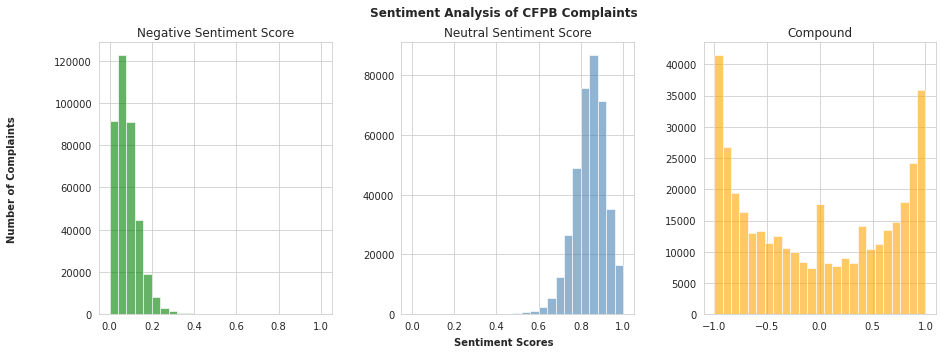

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# plotting all histograms for positive, negative, neutral, compound
dataframe1.hist('neg_sentiment', bins=25, ax=axes[0], color='green', alpha=0.6)
axes[0].set_title('Negative Sentiment Score')
dataframe1.hist('neu_sentiment', bins=25, ax=axes[1], color='steelblue', alpha=0.6)
axes[1].set_title('Neutral Sentiment Score')
dataframe1.hist('comp_sentiment', bins=25, ax=axes[2], color='orange', alpha=0.6)
axes[2].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Complaints', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of CFPB Complaints\n\n', fontsize=12, fontweight='bold');

In [0]:
# all NEGATIVE comments in the dataframe
df_neg = dataframe1.loc[dataframe1.comp_sentiment < 0.0]

# only corpus of NEGATIVE comments
neg_comments = df_neg['Complaint'].tolist()


In [87]:
df_neg['text_length'] = df_neg['Complaint'].apply(len)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


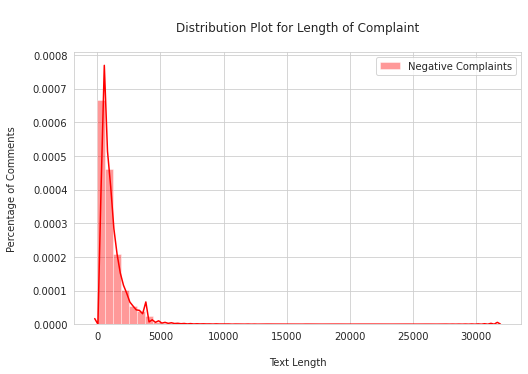

In [91]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_neg['text_length'], kde=True, bins=50, color='red')

plt.title('\nDistribution Plot for Length of Complaint\n')
plt.legend(['Negative Complaints'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');